# 🤖 FEDOT: Многомерное AutoML прогнозирование временных рядов

Этот блокнот реализует многомерное прогнозирование финансовых временных рядов с использованием **FEDOT AutoML** - российской библиотеки автоматического машинного обучения.

## 🎯 Основные особенности

- **Многомерные данные**: используем данные из папки `/data/multivariate_series/`
- **Поэтапные признаки**: различные этапы добавления фичей согласно progressive feature analysis
- **Walk-forward прогнозирование**: честное тестирование с расширяющимся окном
- **Горизонт прогноза**: 10 точек
- **Размер теста**: 11 точек
- **AutoML подход**: автоматический выбор оптимальной архитектуры
- **FEDOT конфигурации**: от быстрого до сбалансированного режима
- **Метрики**: RMSE, MAPE, DA (Directional Accuracy)

## 📊 Структура этапов признаков

1. **Этап 1**: Только цены закрытия (close)
2. **Этап 2**: + Аномалии (anomaly)
3. **Этап 3**: + Новостные настроения (weighted_score_with_decay)
4. **Этап 4**: + Базовые OHLCV признаки
5. **Этап 5**: + Технические индикаторы
6. **Этап 6**: + Статистические признаки (TSFresh)

## 🧠 Методология
- **AutoML прогнозирование**: FEDOT автоматически выбирает оптимальную архитектуру
- **Walk-forward валидация**: строгая проверка на будущих данных с расширяющимся окном
- **Композитные пайплайны**: построение сложных многоуровневых моделей
- **Прогноз**: 10 точек вперед на каждом шаге


In [1]:
# Установка и импорты
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import os
from typing import List, Dict, Tuple, Optional
from datetime import datetime

# Проверка и установка FEDOT
try:
    from fedot import Fedot
    from fedot.core.data.data import InputData
    from fedot.core.data.data_split import train_test_data_setup
    from fedot.core.repository.dataset_types import DataTypesEnum
    from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
    from fedot.core.repository.operation_types_repository import OperationTypesRepository
    print("✅ FEDOT доступен")
except ImportError:
    print("📦 Устанавливаем FEDOT...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "fedot[extra]", "--quiet"])
    from fedot import Fedot
    from fedot.core.data.data import InputData
    from fedot.core.data.data_split import train_test_data_setup
    from fedot.core.repository.dataset_types import DataTypesEnum
    from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
    print("✅ FEDOT установлен и импортирован")

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Настройка визуализации
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

print("📚 Библиотеки загружены успешно!")

✅ FEDOT доступен
📚 Библиотеки загружены успешно!


In [2]:
# Конфигурация (точно как в ML_CHRONOS_Multivariate)
DATA_PATH = "../../data/multivariate_series/"
OUTPUT_PATH = "results/multivariate_fedot/"
FORECAST_HORIZON = 10  # Прогнозируем на 10 точек
TEST_SIZE = 11  # Размер тестового набора

# Создаем папку для результатов
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

# Список тикеров (точно как в ML_CHRONOS_Multivariate)
TICKERS = ['AFLT', 'LKOH', 'MOEX', 'NVTK', 'PIKK', 'SBER', 'VKCO', 'VTBR', 'X5', 'YDEX']

# Названия этапов для отображения (точно как в ML_CHRONOS_Multivariate)
STAGE_NAMES = {
    1: "Базовая цена (close)",
    2: "Цена + аномалии",
    3: "Цена + аномалии + новости",
    4: "Всё выше + OHLCV",
    5: "Всё выше + технические индикаторы",
    6: "Всё выше + статистические признаки"
}

# Конфигурации FEDOT моделей
FEDOT_CONFIGS = {
    'FEDOT_Fast': {
        'timeout_minutes': 1.0,
        'description': 'Быстрый поиск архитектуры (1 мин)',
        'preset': 'ts',
        'with_tuning': False,
        'early_stopping_iterations': 5
    },
    # 'FEDOT_Balanced': {
    #     'timeout_minutes': 5.0,
    #     'description': 'Сбалансированный поиск (5 мин)',
    #     'preset': 'ts',
    #     'with_tuning': True,
    #     'early_stopping_iterations': 10
    # }
}

print(f"Настройки:")
print(f"- Путь к данным: {DATA_PATH}")
print(f"- Горизонт прогноза: {FORECAST_HORIZON}")
print(f"- Размер тест. данных: {TEST_SIZE}")
print(f"- Количество тикеров: {len(TICKERS)}")
print(f"- Папка результатов: {OUTPUT_PATH}")
print(f"- Количество FEDOT конфигураций: {len(FEDOT_CONFIGS)}")

Настройки:
- Путь к данным: ../../data/multivariate_series/
- Горизонт прогноза: 10
- Размер тест. данных: 11
- Количество тикеров: 10
- Папка результатов: results/multivariate_fedot/
- Количество FEDOT конфигураций: 1


In [3]:
# Функции для подготовки признаков по этапам (точно как в ML_CHRONOS_Multivariate)
def prepare_features_for_stage(df: pd.DataFrame, stage: int) -> List[str]:
    """
    Подготавливает список признаков для определенного этапа
    
    Args:
        df: DataFrame с данными
        stage: номер этапа (1-6)
    
    Returns:
        List[str]: список названий колонок для данного этапа
    """
    available_features = set(df.columns)
    
    # Этап 1: Только цена закрытия
    if stage == 1:
        return ['close'] if 'close' in available_features else []
    
    # Этап 2: Цена + аномалии
    elif stage == 2:
        features = ['close']
        if 'anomaly' in available_features:
            features.append('anomaly')
        return [f for f in features if f in available_features]
    
    # Этап 3: Цена + аномалии + новости
    elif stage == 3:
        features = ['close']
        if 'anomaly' in available_features:
            features.append('anomaly')
        if 'weighted_score_with_decay' in available_features:
            features.append('weighted_score_with_decay')
        return [f for f in features if f in available_features]
    
    # Этап 4: Всё выше + OHLCV
    elif stage == 4:
        features = ['close']
        if 'anomaly' in available_features:
            features.append('anomaly')
        if 'weighted_score_with_decay' in available_features:
            features.append('weighted_score_with_decay')
        
        # Добавляем OHLCV
        ohlcv_features = ['open', 'high', 'low', 'volume']
        for feat in ohlcv_features:
            if feat in available_features:
                features.append(feat)
        
        return [f for f in features if f in available_features]
    
    # Этап 5: Всё выше + технические индикаторы
    elif stage == 5:
        features = ['close']
        if 'anomaly' in available_features:
            features.append('anomaly')
        if 'weighted_score_with_decay' in available_features:
            features.append('weighted_score_with_decay')
        
        # OHLCV
        ohlcv_features = ['open', 'high', 'low', 'volume']
        for feat in ohlcv_features:
            if feat in available_features:
                features.append(feat)
        
        # Технические индикаторы
        tech_features = ['EMA_14', 'RSI_14', 'MACD', 'return', 'ATR_14', 'VWAP']
        for feat in tech_features:
            if feat in available_features:
                features.append(feat)
        
        return [f for f in features if f in available_features]
    
    # Этап 6: Всё выше + статистические признаки
    elif stage == 6:
        features = ['close']
        if 'anomaly' in available_features:
            features.append('anomaly')
        if 'weighted_score_with_decay' in available_features:
            features.append('weighted_score_with_decay')
        
        # OHLCV
        ohlcv_features = ['open', 'high', 'low', 'volume']
        for feat in ohlcv_features:
            if feat in available_features:
                features.append(feat)
        
        # Технические индикаторы
        tech_features = ['EMA_14', 'RSI_14', 'MACD', 'return', 'ATR_14', 'VWAP']
        for feat in tech_features:
            if feat in available_features:
                features.append(feat)
        
        # Статистические признаки (выборочно TSFresh)
        tsfresh_stats = [
            'value__mean',
            'value__maximum',
            'value__minimum',
            'value__standard_deviation',
            'value__partial_autocorrelation__lag_3',
            'value__autocorrelation__lag_5',
            'value__longest_strike_above_mean'
        ]
        for feat in tsfresh_stats:
            if feat in available_features:
                features.append(feat)
        
        return [f for f in features if f in available_features]
    
    else:
        return ['close'] if 'close' in available_features else []

print("Функции для подготовки признаков созданы")

Функции для подготовки признаков созданы


In [4]:
# Вспомогательные функции для оценки (точно как в ML_CHRONOS_Multivariate)
def calculate_directional_accuracy(actual: np.ndarray, predicted: np.ndarray) -> float:
    """Вычисляет точность направления (DA)"""
    if len(actual) < 2 or len(predicted) < 2:
        return 0.0
    
    actual_direction = np.diff(actual) > 0
    predicted_direction = np.diff(predicted) > 0
    
    return np.mean(actual_direction == predicted_direction) * 100

def load_ticker_data(ticker: str) -> Optional[pd.DataFrame]:
    """Загружает данные для тикера (точно как в ML_CHRONOS_Multivariate)"""
    file_path = f"{DATA_PATH}{ticker}_multivariate.csv"
    
    if not os.path.exists(file_path):
        print(f"⚠️ Файл не найден: {file_path}")
        return None
    
    try:
        df = pd.read_csv(file_path)
        
        # Проверяем наличие timestamp колонки
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df = df.set_index('timestamp')
        
        # Сортируем по времени
        df = df.sort_index()
        
        # Проверяем наличие основных колонок
        required_cols = ['close']
        if not all(col in df.columns for col in required_cols):
            print(f"⚠️ Отсутствуют необходимые колонки в {ticker}")
            return None
        
        print(f"✅ Загружен {ticker}: {len(df)} точек, {len(df.columns)} признаков")
        return df
        
    except Exception as e:
        print(f"❌ Ошибка загрузки {ticker}: {e}")
        return None

def create_fedot_input_data(values: np.ndarray, 
                           timestamps: np.ndarray,
                           forecast_length: int = 1) -> InputData:
    """Создает InputData для FEDOT из временного ряда"""
    task = Task(
        TaskTypesEnum.ts_forecasting,
        TsForecastingParams(forecast_length=forecast_length)
    )
    return InputData.from_numpy_time_series(
        features_array=values,
        target_array=values,  # для ts_forecasting features == target
        idx=timestamps,
        task=task,
        data_type=DataTypesEnum.ts
    )

print("Вспомогательные функции созданы")

Вспомогательные функции созданы


In [5]:
# Основная функция для оценки FEDOT моделей
def evaluate_fedot_model(df: pd.DataFrame, ticker: str, stage: int, 
                        config_name: str, config: Dict) -> Optional[Dict]:
    """
    Обучает и оценивает FEDOT модель на данных тикера для определенного этапа
    
    Args:
        df: DataFrame с данными тикера
        ticker: название тикера
        stage: номер этапа
        config_name: название конфигурации FEDOT
        config: параметры конфигурации
        
    Returns:
        Dict с результатами или None при ошибке
    """
    
    #try:
    # Подготавливаем признаки для этапа
    feature_columns = prepare_features_for_stage(df, stage)
    
    if len(feature_columns) == 0:
        print(f"  ⚠️ Нет доступных признаков для {ticker} на этапе {stage}")
        return None
    
    # Проверяем наличие всех колонок
    available_features = [col for col in feature_columns if col in df.columns]
    
    if len(available_features) == 0:
        print(f"  ⚠️ Нет доступных признаков для {ticker} на этапе {stage}")
        return None
    
    # Удаляем строки с NaN в выбранных признаках
    df_clean = df[available_features].dropna()
    
    if len(df_clean) < TEST_SIZE + 20:  # Минимальный размер для обучения
        print(f"  ⚠️ Недостаточно данных для {ticker} на этапе {stage}")
        return None
    
    print(f"  🤖 Создание FEDOT модели ({config_name})...")
    print(f"  📊 Признаки этапа {stage}: {', '.join(available_features)}")
    
    # Подготавливаем целевую переменную (цена закрытия)
    target_series = df_clean['close'].values
    timestamps = np.arange(len(target_series))
    
    # Walk-forward предсказание
    predictions = []
    
    # Начинаем с последних TEST_SIZE точек
    start_idx = len(target_series) - TEST_SIZE
    
    print(f"  🎯 Walk-forward прогнозирование FEDOT: {FORECAST_HORIZON} шагов")
    
    step_times = []
    model = None
    
    for i in range(FORECAST_HORIZON):
        step_start = time.time()
        
        # Определяем текущую позицию
        current_pos = start_idx + i
        
        # Берем исторические данные до current_pos
        hist_data = target_series[:current_pos]
        hist_timestamps = timestamps[:current_pos]
        
        # Проверяем размер данных
        if len(hist_data) < 20:  # Минимальный размер
            print(f"    ⚠️ Недостаточно данных для шага {i+1}")
            predictions.append(np.nan)
            step_times.append(time.time() - step_start)
            continue
        
        # Если первый шаг - обучаем модель
        if i == 0:
            print(f"    🚀 Обучение FEDOT модели на {len(hist_data)} точках...")
            training_start = time.time()

            repo = OperationTypesRepository('model')          # или 'data_operation'
            operations = repo.operations                     # список OperationType
            
            # Создаем FEDOT модель
            model = Fedot(
                problem='ts_forecasting',
                timeout=config['timeout_minutes'],
                preset=config['preset'],
                n_jobs=1,
                safe_mode=True,
                cv_folds=3,
                early_stopping_iterations=config['early_stopping_iterations'],
                with_tuning=config['with_tuning']
            )
            
            # Создаем InputData для обучения
            input_train = create_fedot_input_data(
                values=hist_data,
                timestamps=hist_timestamps,
                forecast_length=1
            )
            
            # Обучаем модель
            model.fit(features=input_train, target=hist_data)
            
            training_time = time.time() - training_start
            print(f"    ✅ Модель обучена за {training_time:.2f}с")
            print(f"    📋 Найденная архитектура: {model.current_pipeline}")
        
        try:
            # Создаем InputData для прогноза
            input_forecast = create_fedot_input_data(
                values=hist_data,
                timestamps=hist_timestamps,
                forecast_length=1
            )
            
            # Разделяем данные для out-of-sample прогноза
            train_data, forecast_data = train_test_data_setup(input_forecast)
            
            # Делаем прогноз
            raw_forecast = model.forecast(forecast_data)
            
            # Извлекаем прогнозное значение
            if hasattr(raw_forecast, 'predict'):
                y_pred = float(raw_forecast.predict[0])
            elif isinstance(raw_forecast, np.ndarray):
                y_pred = float(raw_forecast[0])
            elif isinstance(raw_forecast, list):
                y_pred = float(raw_forecast[0])
            else:
                y_pred = float(raw_forecast)
            
            predictions.append(y_pred)
            
            step_time = time.time() - step_start
            step_times.append(step_time)
            
            print(f"    📈 Шаг {i+1}: прогноз={y_pred:.4f}, время={step_time:.3f}с")
            
        except Exception as e:
            print(f"    ❌ Ошибка прогноза на шаге {i+1}: {e}")
            predictions.append(np.nan)
            step_times.append(time.time() - step_start)
            continue
    
    # Фильтруем NaN значения
    predictions = np.array(predictions)
    valid_mask = ~np.isnan(predictions)
    
    if np.sum(valid_mask) == 0:
        print(f"  ❌ Нет валидных прогнозов для {ticker}")
        return None
    
    predictions_clean = predictions[valid_mask]
    
    # Получаем соответствующие фактические значения
    actual_values = target_series[start_idx:start_idx + len(predictions)]
    actual_clean = actual_values[valid_mask]
    
    # Вычисляем метрики
    mae = mean_absolute_error(actual_clean, predictions_clean)
    rmse = mean_squared_error(actual_clean, predictions_clean, squared=False)
    mape = mean_absolute_percentage_error(actual_clean, predictions_clean) * 100
    da = calculate_directional_accuracy(actual_clean, predictions_clean)
    
    avg_time = np.mean(step_times)
    
    print(f"  📊 Результаты для {ticker} (этап {stage}, {config_name}):")
    print(f"    MAE: {mae:.4f}")
    print(f"    RMSE: {rmse:.4f}")
    print(f"    MAPE: {mape:.2f}%")
    print(f"    DA: {da:.2f}%")
    print(f"    Среднее время: {avg_time:.3f}с")
    return {
        'ticker': ticker,
        'stage': stage,
        'config_name': config_name,
        'predictions': predictions_clean,
        'actual': actual_clean,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'da': da,
        'time': avg_time,
        'features': available_features,
        'model_description': str(model.current_pipeline) if model else 'N/A'
    }
    
    #except Exception as e:
    #    print(f"  ❌ Ошибка при оценке {ticker}: {e}")
    #    return None
        
print("Функция оценки FEDOT модели создана")

Функция оценки FEDOT модели создана


In [6]:
# Основной пайплайн экспериментов
print("🚀 ЗАПУСК МНОГОМЕРНОГО FEDOT AUTOML ЭКСПЕРИМЕНТА")
print("=" * 60)

# Инициализация результатов
results = []

# Выбираем этапы для тестирования (как в CHRONOS)
test_stages = [6]  # Базовая цена и полный набор признаков

print(f"📊 Тестируем этапы: {test_stages}")
print(f"🎯 Тикеры: {TICKERS}")
print(f"⚡ Конфигурации FEDOT: {list(FEDOT_CONFIGS.keys())}")
print(f"⏱️ Это может занять значительное время (AutoML требует поиска архитектуры)...")

OperationTypesRepository.init_default_repositories()

# Счетчик прогресса
total_experiments = len(TICKERS) * len(test_stages) * len(FEDOT_CONFIGS)
current_experiment = 0

for ticker in TICKERS:
    print(f"\\n{'='*80}")
    print(f"📈 ОБРАБОТКА ТИКЕРА: {ticker}")
    print(f"{'='*80}")
    
    # Загружаем данные тикера
    df = load_ticker_data(ticker)
    if df is None:
        print(f"⏭️ Пропускаем {ticker} - нет данных")
        continue
        
    # Тестируем каждый этап
    for stage in test_stages:
        print(f"\n🔬 ЭТАП {stage}: {STAGE_NAMES[stage]}")
        print("-" * 50)
        # Тестируем каждую конфигурацию FEDOT
        for config_name, config in FEDOT_CONFIGS.items():
            current_experiment += 1
            progress = (current_experiment / total_experiments) * 100
            
            print(f"\n📊 Эксперимент {current_experiment}/{total_experiments} ({progress:.1f}%)")
            print(f"🤖 Конфигурация: {config_name} - {config['description']}")
            # Запускаем оценку модели
            experiment_start = time.time()
            result = evaluate_fedot_model(
                df=df,
                ticker=ticker,
                stage=stage,
                config_name=config_name,
                config=config
            )
            experiment_time = time.time() - experiment_start
            
            if result is not None:
                # Добавляем время эксперимента
                result['experiment_time'] = experiment_time
                results.append(result)
                print(f"✅ Эксперимент завершен за {experiment_time:.1f}с")
            else:
                print(f"❌ Эксперимент не удался")
                
                print(f"\n{'='*80}")
                print(f"🎉 ВСЕ ЭКСПЕРИМЕНТЫ ЗАВЕРШЕНЫ!")
                print(f"📊 Успешных результатов: {len(results)} из {total_experiments}")
                print(f"{'='*80}")

🚀 ЗАПУСК МНОГОМЕРНОГО FEDOT AUTOML ЭКСПЕРИМЕНТА
📊 Тестируем этапы: [6]
🎯 Тикеры: ['AFLT', 'LKOH', 'MOEX', 'NVTK', 'PIKK', 'SBER', 'VKCO', 'VTBR', 'X5', 'YDEX']
⚡ Конфигурации FEDOT: ['FEDOT_Fast']
⏱️ Это может занять значительное время (AutoML требует поиска архитектуры)...


2025-06-22 16:11:32.833721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-22 16:11:35.686128: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /workspace/predictors/univariate/venvs/fedot/lib/python3.10/site-packages/cv2/../../lib64:
2025-06-22 16:11:35.686162: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-06-22 16:11:44.177385: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library

\n================================================================================
📈 ОБРАБОТКА ТИКЕРА: AFLT
✅ Загружен AFLT: 2356 точек, 918 признаков

🔬 ЭТАП 6: Всё выше + статистические признаки
--------------------------------------------------

📊 Эксперимент 1/10 (10.0%)
🤖 Конфигурация: FEDOT_Fast - Быстрый поиск архитектуры (1 мин)
  🤖 Создание FEDOT модели (FEDOT_Fast)...
  📊 Признаки этапа 6: close, anomaly, weighted_score_with_decay, open, high, low, volume, EMA_14, RSI_14, MACD, return, ATR_14, VWAP, value__mean, value__maximum, value__minimum, value__standard_deviation, value__partial_autocorrelation__lag_3, value__autocorrelation__lag_5, value__longest_strike_above_mean
  🎯 Walk-forward прогнозирование FEDOT: 10 шагов
    🚀 Обучение FEDOT модели на 2339 точках...
2025-06-22 16:12:04,701 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 115
2025-06-22 16:12:04,948 - ApiComposer - Initial pipeline was fitted

Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2025-06-22 16:12:06,705 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 283
2025-06-22 16:12:08,958 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 283
2025-06-22 16:12:10,144 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 283
2025-06-22 16:12:21,202 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 283
2025-06-22 16:12:22,174 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2025-06-22 16:13:29,721 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 0/10000 [01:24<?, ?gen/s]

2025-06-22 16:13:29,894 - ApiComposer - Model generation finished


2025-06-22 16:13:29,957 - FEDOT logger - Final pipeline was fitted
2025-06-22 16:13:29,959 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [ar, smoothing]}
ar - {'lag_1': 7, 'lag_2': 12}
smoothing - {}
    ✅ Модель обучена за 85.41с
    📋 Найденная архитектура: {'depth': 2, 'length': 2, 'nodes': [ar, smoothing]}
    📈 Шаг 1: прогноз=66.4607, время=85.419с
    📈 Шаг 2: прогноз=66.4607, время=0.011с
    📈 Шаг 3: прогноз=67.3195, время=0.011с
    📈 Шаг 4: прогноз=67.7921, время=0.010с
    📈 Шаг 5: прогноз=68.0796, время=0.011с
    📈 Шаг 6: прогноз=68.9271, время=0.011с
    📈 Шаг 7: прогноз=69.1615, время=0.011с
    📈 Шаг 8: прогноз=70.1063, время=0.011с
    📈 Шаг 9: прогноз=71.3738, время=0.010с
    📈 Шаг 10: прогноз=72.0159, время=0.009с
  📊 Результаты для AFLT (этап 6, FEDOT_Fast):
    MAE: 4.3785
    RMSE: 4.6435
    MAPE: 5.99%
    DA: 33.33%
    Среднее время: 8.551с
✅ Эксперимент завершен за 85.5с
\n================================================================

Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2025-06-22 16:13:32,758 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 194
2025-06-22 16:13:34,904 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 194
2025-06-22 16:13:35,389 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 194
2025-06-22 16:13:40,680 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 194
2025-06-22 16:13:41,757 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2025-06-22 16:16:24,833 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 0/10000 [02:53<?, ?gen/s]

2025-06-22 16:16:25,004 - ApiComposer - Model generation finished


2025-06-22 16:16:25,075 - FEDOT logger - Final pipeline was fitted
2025-06-22 16:16:25,076 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [ar, smoothing]}
ar - {'lag_1': 7, 'lag_2': 12}
smoothing - {}
    ✅ Модель обучена за 174.50с
    📋 Найденная архитектура: {'depth': 2, 'length': 2, 'nodes': [ar, smoothing]}
    📈 Шаг 1: прогноз=6344.8161, время=174.508с
    📈 Шаг 2: прогноз=6344.8161, время=0.011с
    📈 Шаг 3: прогноз=6325.4184, время=0.012с
    📈 Шаг 4: прогноз=6331.9910, время=0.012с
    📈 Шаг 5: прогноз=6357.9428, время=0.010с
    📈 Шаг 6: прогноз=6394.9523, время=0.011с
    📈 Шаг 7: прогноз=6407.8410, время=0.010с
    📈 Шаг 8: прогноз=6491.6244, время=0.011с
    📈 Шаг 9: прогноз=6561.9972, время=0.010с
    📈 Шаг 10: прогноз=6596.4371, время=0.011с
  📊 Результаты для LKOH (этап 6, FEDOT_Fast):
    MAE: 362.1164
    RMSE: 377.2227
    MAPE: 5.33%
    DA: 33.33%
    Среднее время: 17.461с
✅ Эксперимент завершен за 174.6с
\n====================================

Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2025-06-22 16:16:28,102 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 301
2025-06-22 16:16:30,416 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 301
2025-06-22 16:16:31,460 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 301
2025-06-22 16:16:43,896 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 301
2025-06-22 16:16:45,063 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2025-06-22 16:21:41,454 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 0/10000 [05:14<?, ?gen/s]

2025-06-22 16:21:41,621 - ApiComposer - Model generation finished


2025-06-22 16:21:41,689 - FEDOT logger - Final pipeline was fitted
2025-06-22 16:21:41,691 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [ar, smoothing]}
ar - {'lag_1': 7, 'lag_2': 12}
smoothing - {}
    ✅ Модель обучена за 315.96с
    📋 Найденная архитектура: {'depth': 2, 'length': 2, 'nodes': [ar, smoothing]}
    📈 Шаг 1: прогноз=193.5632, время=315.974с
    📈 Шаг 2: прогноз=193.5632, время=0.009с
    📈 Шаг 3: прогноз=192.8294, время=0.009с
    📈 Шаг 4: прогноз=192.6279, время=0.009с
    📈 Шаг 5: прогноз=192.3765, время=0.010с
    📈 Шаг 6: прогноз=192.6172, время=0.009с
    📈 Шаг 7: прогноз=192.3092, время=0.009с
    📈 Шаг 8: прогноз=193.1142, время=0.009с
    📈 Шаг 9: прогноз=193.4084, время=0.009с
    📈 Шаг 10: прогноз=193.8678, время=0.009с
  📊 Результаты для MOEX (этап 6, FEDOT_Fast):
    MAE: 10.9989
    RMSE: 12.1063
    MAPE: 5.34%
    DA: 33.33%
    Среднее время: 31.606с
✅ Эксперимент завершен за 316.1с
\n================================================

Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2025-06-22 16:21:44,760 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 144
2025-06-22 16:21:46,818 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 144
2025-06-22 16:21:47,293 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 144
2025-06-22 16:21:52,168 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 144
2025-06-22 16:21:53,338 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2025-06-22 16:22:03,543 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 144
2025-06-22 16:22:05,368 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSize

Generations:   0%|          | 0/10000 [01:36<?, ?gen/s]

2025-06-22 16:23:20,455 - ApiComposer - Model generation finished


2025-06-22 16:23:20,516 - FEDOT logger - Final pipeline was fitted
2025-06-22 16:23:20,519 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [ar, smoothing]}
ar - {'lag_1': 7, 'lag_2': 12}
smoothing - {'window_size': 9}
    ✅ Модель обучена за 98.20с
    📋 Найденная архитектура: {'depth': 2, 'length': 2, 'nodes': [ar, smoothing]}
    📈 Шаг 1: прогноз=1120.1396, время=98.208с
    📈 Шаг 2: прогноз=1120.1396, время=0.007с
    📈 Шаг 3: прогноз=1110.5657, время=0.007с
    📈 Шаг 4: прогноз=1095.9548, время=0.007с
    📈 Шаг 5: прогноз=1087.4282, время=0.007с
    📈 Шаг 6: прогноз=1095.1888, время=0.007с
    📈 Шаг 7: прогноз=1094.6062, время=0.007с
    📈 Шаг 8: прогноз=1097.2351, время=0.007с
    📈 Шаг 9: прогноз=1115.8947, время=0.007с
    📈 Шаг 10: прогноз=1148.3826, время=0.007с
  📊 Результаты для NVTK (этап 6, FEDOT_Fast):
    MAE: 127.9065
    RMSE: 135.6526
    MAPE: 10.26%
    DA: 22.22%
    Среднее время: 9.827с
✅ Эксперимент завершен за 98.3с
\n=======================

Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2025-06-22 16:23:23,552 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 169
2025-06-22 16:23:25,490 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 169
2025-06-22 16:23:25,995 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 169
2025-06-22 16:23:30,833 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 169
2025-06-22 16:23:31,930 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2025-06-22 17:11:48,097 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 0/10000 [48:25<?, ?gen/s]

2025-06-22 17:11:48,274 - ApiComposer - Model generation finished


2025-06-22 17:11:48,507 - FEDOT logger - Final pipeline was fitted
2025-06-22 17:11:48,511 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 4, 'nodes': [ridge, polyfit, ridge, lagged]}
ridge - {}
polyfit - {'degree': 2}
ridge - {}
lagged - {'window_size': 169}
    ✅ Модель обучена за 2907.38с
    📋 Найденная архитектура: {'depth': 3, 'length': 4, 'nodes': [ridge, polyfit, ridge, lagged]}
    ❌ Ошибка прогноза на шаге 1: X has 31 features, but Ridge is expecting 60 features as input.
    ❌ Ошибка прогноза на шаге 2: X has 31 features, but Ridge is expecting 60 features as input.
    ❌ Ошибка прогноза на шаге 3: X has 31 features, but Ridge is expecting 60 features as input.
    ❌ Ошибка прогноза на шаге 4: X has 31 features, but Ridge is expecting 60 features as input.
    ❌ Ошибка прогноза на шаге 5: X has 31 features, but Ridge is expecting 60 features as input.
    ❌ Ошибка прогноза на шаге 6: X has 31 features, but Ridge is expecting 60 features as input.
    ❌ Ошибка прогноз

Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2025-06-22 17:11:51,338 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 276
2025-06-22 17:11:53,597 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 276
2025-06-22 17:11:54,189 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 276
2025-06-22 17:12:00,324 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 276
2025-06-22 17:12:01,406 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2025-06-22 17:13:07,576 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 0/10000 [01:17<?, ?gen/s]

2025-06-22 17:13:07,753 - ApiComposer - Model generation finished


2025-06-22 17:13:07,826 - FEDOT logger - Final pipeline was fitted
2025-06-22 17:13:07,829 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [ar, smoothing]}
ar - {'lag_1': 7, 'lag_2': 12}
smoothing - {}
    ✅ Модель обучена за 78.63с
    📋 Найденная архитектура: {'depth': 2, 'length': 2, 'nodes': [ar, smoothing]}
    📈 Шаг 1: прогноз=286.9449, время=78.644с
    📈 Шаг 2: прогноз=286.9449, время=0.010с
    📈 Шаг 3: прогноз=287.4283, время=0.011с
    📈 Шаг 4: прогноз=288.7428, время=0.012с
    📈 Шаг 5: прогноз=290.9334, время=0.012с
    📈 Шаг 6: прогноз=294.1658, время=0.010с
    📈 Шаг 7: прогноз=296.0880, время=0.011с
    📈 Шаг 8: прогноз=299.2270, время=0.011с
    📈 Шаг 9: прогноз=302.1919, время=0.010с
    📈 Шаг 10: прогноз=303.8672, время=0.013с
  📊 Результаты для SBER (этап 6, FEDOT_Fast):
    MAE: 18.0096
    RMSE: 18.8702
    MAPE: 5.77%
    DA: 55.56%
    Среднее время: 7.874с
✅ Эксперимент завершен за 78.7с
\n====================================================

Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2025-06-22 17:13:09,907 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 17
2025-06-22 17:13:11,268 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 17
2025-06-22 17:13:11,513 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 17
2025-06-22 17:13:13,616 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 17
2025-06-22 17:13:14,298 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2025-06-22 17:13:30,085 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 17
2025-06-22 17:14:06,263 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.

Generations:   0%|          | 0/10000 [00:57<?, ?gen/s]

2025-06-22 17:14:06,504 - ApiComposer - Model generation finished


2025-06-22 17:14:06,584 - FEDOT logger - Final pipeline was fitted
2025-06-22 17:14:06,591 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [ridge, lagged]}
ridge - {}
lagged - {'window_size': 17}
    ✅ Модель обучена за 58.39с
    📋 Найденная архитектура: {'depth': 2, 'length': 2, 'nodes': [ridge, lagged]}
    📈 Шаг 1: прогноз=250.0618, время=58.441с
    📈 Шаг 2: прогноз=254.1934, время=0.036с
    📈 Шаг 3: прогноз=247.6951, время=0.011с
    📈 Шаг 4: прогноз=256.6234, время=0.010с
    📈 Шаг 5: прогноз=272.5303, время=0.012с
    📈 Шаг 6: прогноз=271.2890, время=0.013с
    📈 Шаг 7: прогноз=274.0793, время=0.012с
    📈 Шаг 8: прогноз=282.7761, время=0.014с
    📈 Шаг 9: прогноз=280.7250, время=0.015с
    📈 Шаг 10: прогноз=284.2119, время=0.013с
  📊 Результаты для VKCO (этап 6, FEDOT_Fast):
    MAE: 9.5812
    RMSE: 12.9452
    MAPE: 3.51%
    DA: 44.44%
    Среднее время: 5.858с
✅ Эксперимент завершен за 58.6с
\n===========================================================

Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2025-06-22 17:14:09,592 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 247
2025-06-22 17:14:12,064 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 247
2025-06-22 17:14:12,602 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 247
2025-06-22 17:14:17,531 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 247
2025-06-22 17:14:18,438 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2025-06-22 17:15:08,963 - MultiprocessingDispatcher - 13 individuals out of 21 in previous population were evaluated successfully.
2025-06-22 17:15:08,991 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 0/10000 [01:00<?, ?gen/s]

2025-06-22 17:15:09,178 - ApiComposer - Model generation finished


2025-06-22 17:15:09,239 - FEDOT logger - Final pipeline was fitted
2025-06-22 17:15:09,240 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [ar, gaussian_filter]}
ar - {'lag_1': 7, 'lag_2': 12}
gaussian_filter - {}
    ✅ Модель обучена за 62.05с
    📋 Найденная архитектура: {'depth': 2, 'length': 2, 'nodes': [ar, gaussian_filter]}
    📈 Шаг 1: прогноз=77.4717, время=62.063с
    📈 Шаг 2: прогноз=77.4717, время=0.011с
    📈 Шаг 3: прогноз=79.1714, время=0.011с
    📈 Шаг 4: прогноз=79.2417, время=0.012с
    📈 Шаг 5: прогноз=78.5216, время=0.012с
    📈 Шаг 6: прогноз=79.1402, время=0.011с
    📈 Шаг 7: прогноз=81.2872, время=0.013с
    📈 Шаг 8: прогноз=83.6437, время=0.012с
    📈 Шаг 9: прогноз=85.4308, время=0.012с
    📈 Шаг 10: прогноз=86.8858, время=0.012с
  📊 Результаты для VTBR (этап 6, FEDOT_Fast):
    MAE: 7.6524
    RMSE: 8.0135
    MAPE: 8.56%
    DA: 55.56%
    Среднее время: 6.217с
✅ Эксперимент завершен за 62.2с
\n==============================================

Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2025-06-22 17:15:11,473 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 103
2025-06-22 17:15:13,140 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 103
2025-06-22 17:15:13,399 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 103
2025-06-22 17:15:16,415 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 103
2025-06-22 17:15:17,281 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2025-06-22 17:15:26,186 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 103
2025-06-22 17:15:33,999 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSize

Generations:   0%|          | 0/10000 [02:02<?, ?gen/s]

2025-06-22 17:17:13,062 - ApiComposer - Model generation finished


2025-06-22 17:17:13,124 - FEDOT logger - Final pipeline was fitted
2025-06-22 17:17:13,126 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [ar, gaussian_filter]}
ar - {'lag_1': 7, 'lag_2': 12}
gaussian_filter - {}
    ✅ Модель обучена за 123.46с
    📋 Найденная архитектура: {'depth': 2, 'length': 2, 'nodes': [ar, gaussian_filter]}
    📈 Шаг 1: прогноз=2241.1152, время=123.471с
    📈 Шаг 2: прогноз=2241.1152, время=0.009с
    📈 Шаг 3: прогноз=2255.6003, время=0.009с
    📈 Шаг 4: прогноз=2286.6517, время=0.009с
    📈 Шаг 5: прогноз=2304.7648, время=0.010с
    📈 Шаг 6: прогноз=2299.0042, время=0.009с
    📈 Шаг 7: прогноз=2275.2630, время=0.010с
    📈 Шаг 8: прогноз=2249.9201, время=0.010с
    📈 Шаг 9: прогноз=2232.4581, время=0.012с
    📈 Шаг 10: прогноз=2238.9290, время=0.014с
  📊 Результаты для X5 (этап 6, FEDOT_Fast):
    MAE: 51.2674
    RMSE: 74.6437
    MAPE: 2.19%
    DA: 55.56%
    Среднее время: 12.356с
✅ Эксперимент завершен за 123.6с
\n======================

Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2025-06-22 17:17:15,930 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 29
2025-06-22 17:17:17,923 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 29
2025-06-22 17:17:18,369 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 29
2025-06-22 17:17:22,293 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 29
2025-06-22 17:17:23,395 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2025-06-22 17:17:33,637 - SparseLaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 29
2025-06-22 17:18:32,009 - MultiprocessingDispatcher - 11 individuals out of 21 in previous population were evaluated successfully.

Generations:   0%|          | 0/10000 [01:17<?, ?gen/s]

2025-06-22 17:18:32,203 - ApiComposer - Model generation finished


2025-06-22 17:18:32,273 - FEDOT logger - Final pipeline was fitted
2025-06-22 17:18:32,279 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [ridge, lagged]}
ridge - {}
lagged - {'window_size': 29}
    ✅ Модель обучена за 78.60с
    📋 Найденная архитектура: {'depth': 2, 'length': 2, 'nodes': [ridge, lagged]}
    📈 Шаг 1: прогноз=4109.0994, время=78.616с
    📈 Шаг 2: прогноз=4180.6772, время=0.022с
    📈 Шаг 3: прогноз=4200.0541, время=0.020с
    📈 Шаг 4: прогноз=4228.2789, время=0.019с
    📈 Шаг 5: прогноз=4185.8010, время=0.019с
    📈 Шаг 6: прогноз=4331.8015, время=0.011с
    📈 Шаг 7: прогноз=4362.5374, время=0.009с
    📈 Шаг 8: прогноз=4260.8206, время=0.012с
    📈 Шаг 9: прогноз=4292.2104, время=0.011с
    📈 Шаг 10: прогноз=4355.4762, время=0.010с
  📊 Результаты для YDEX (этап 6, FEDOT_Fast):
    MAE: 89.0903
    RMSE: 108.4856
    MAPE: 2.08%
    DA: 33.33%
    Среднее время: 7.875с
✅ Эксперимент завершен за 78.8с


In [9]:
# Анализ и сохранение результатов
if results:
    print("📊 АНАЛИЗ РЕЗУЛЬТАТОВ FEDOT AUTOML")
    print("=" * 50)
    
    # Создаем DataFrame с результатами
    df_results = pd.DataFrame(results)
    
    # Показываем общую статистику
    print(f"📈 Общая статистика:")
    print(f"  Всего экспериментов: {len(df_results)}")
    print(f"  Уникальных тикеров: {df_results['ticker'].nunique()}")
    print(f"  Этапов: {sorted(df_results['stage'].unique())}")
    print(f"  Конфигураций: {sorted(df_results['config_name'].unique())}")
    
    # Средние метрики
    print(f"\\n📊 Средние метрики:")
    print(f"  RMSE: {df_results['rmse'].mean():.4f} (±{df_results['rmse'].std():.4f})")
    print(f"  MAPE: {df_results['mape'].mean():.2f}% (±{df_results['mape'].std():.2f}%)")
    print(f"  DA: {df_results['da'].mean():.2f}% (±{df_results['da'].std():.2f}%)")
    print(f"  Время: {df_results['time'].mean():.3f}с (±{df_results['time'].std():.3f}с)")
    
    # Лучшие результаты по каждой метрике
    print(f"\\n🏆 Лучшие результаты:")
    
    # Лучший RMSE
    best_rmse = df_results.loc[df_results['rmse'].idxmin()]
    print(f"  Лучший RMSE: {best_rmse['rmse']:.4f} ({best_rmse['ticker']}, {best_rmse['config_name']}, этап {best_rmse['stage']})")
    
    # Лучший MAPE
    best_mape = df_results.loc[df_results['mape'].idxmin()]
    print(f"  Лучший MAPE: {best_mape['mape']:.2f}% ({best_mape['ticker']}, {best_mape['config_name']}, этап {best_mape['stage']})")
    
    # Лучший DA
    best_da = df_results.loc[df_results['da'].idxmax()]
    print(f"  Лучший DA: {best_da['da']:.2f}% ({best_da['ticker']}, {best_da['config_name']}, этап {best_da['stage']})")
    
    # Сравнение конфигураций
    print(f"\n⚖️ Сравнение конфигураций FEDOT:")
    config_comparison = df_results.groupby('config_name').agg({
        'rmse': ['mean', 'std'],
        'mape': ['mean', 'std'],
        'da': ['mean', 'std'],
        'time': ['mean', 'std'],
        'experiment_time': ['mean', 'std']
    }).round(4)
    
    print(config_comparison)
    
    # Сравнение этапов
    if len(df_results['stage'].unique()) > 1:
        print(f"\n📈 Сравнение этапов:")
        stage_comparison = df_results.groupby('stage').agg({
            'rmse': ['mean', 'std'],
            'mape': ['mean', 'std'],
            'da': ['mean', 'std']
        }).round(4)
        
        print(stage_comparison)
        # Сохраняем результаты
        
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        results_file = f"{OUTPUT_PATH}multivariate_fedot_results_{timestamp}.csv"
        
        # Подготавливаем данные для сохранения (убираем массивы)
        df_save = df_results.drop(['predictions', 'actual'], axis=1, errors='ignore')
        df_save.to_csv(results_file, index=False)
        print(f"\n💾 Результаты сохранены: {results_file}")
    else:
        print("❌ Нет результатов для анализа!")

📊 АНАЛИЗ РЕЗУЛЬТАТОВ FEDOT AUTOML
📈 Общая статистика:
  Всего экспериментов: 9
  Уникальных тикеров: 9
  Этапов: [6]
  Конфигураций: ['FEDOT_Fast']
\n📊 Средние метрики:
  RMSE: 83.6204 (±120.3454)
  MAPE: 5.45% (±2.71%)
  DA: 40.74% (±12.42%)
  Время: 11.958с (±8.186с)
\n🏆 Лучшие результаты:
  Лучший RMSE: 4.6435 (AFLT, FEDOT_Fast, этап 6)
  Лучший MAPE: 2.08% (YDEX, FEDOT_Fast, этап 6)
  Лучший DA: 55.56% (SBER, FEDOT_Fast, этап 6)

⚖️ Сравнение конфигураций FEDOT:
                rmse              mape              da              time  \
                mean       std    mean    std     mean      std     mean   
config_name                                                                
FEDOT_Fast   83.6204  120.3454  5.4473  2.714  40.7407  12.4226  11.9583   

                    experiment_time           
                std            mean      std  
config_name                                   
FEDOT_Fast   8.1864        119.5884  81.8628  
❌ Нет результатов для анализа!


📊 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ FEDOT AUTOML
📊 График сохранен: results/multivariate_fedot/multivariate_fedot_comparison_20250622_172749.png


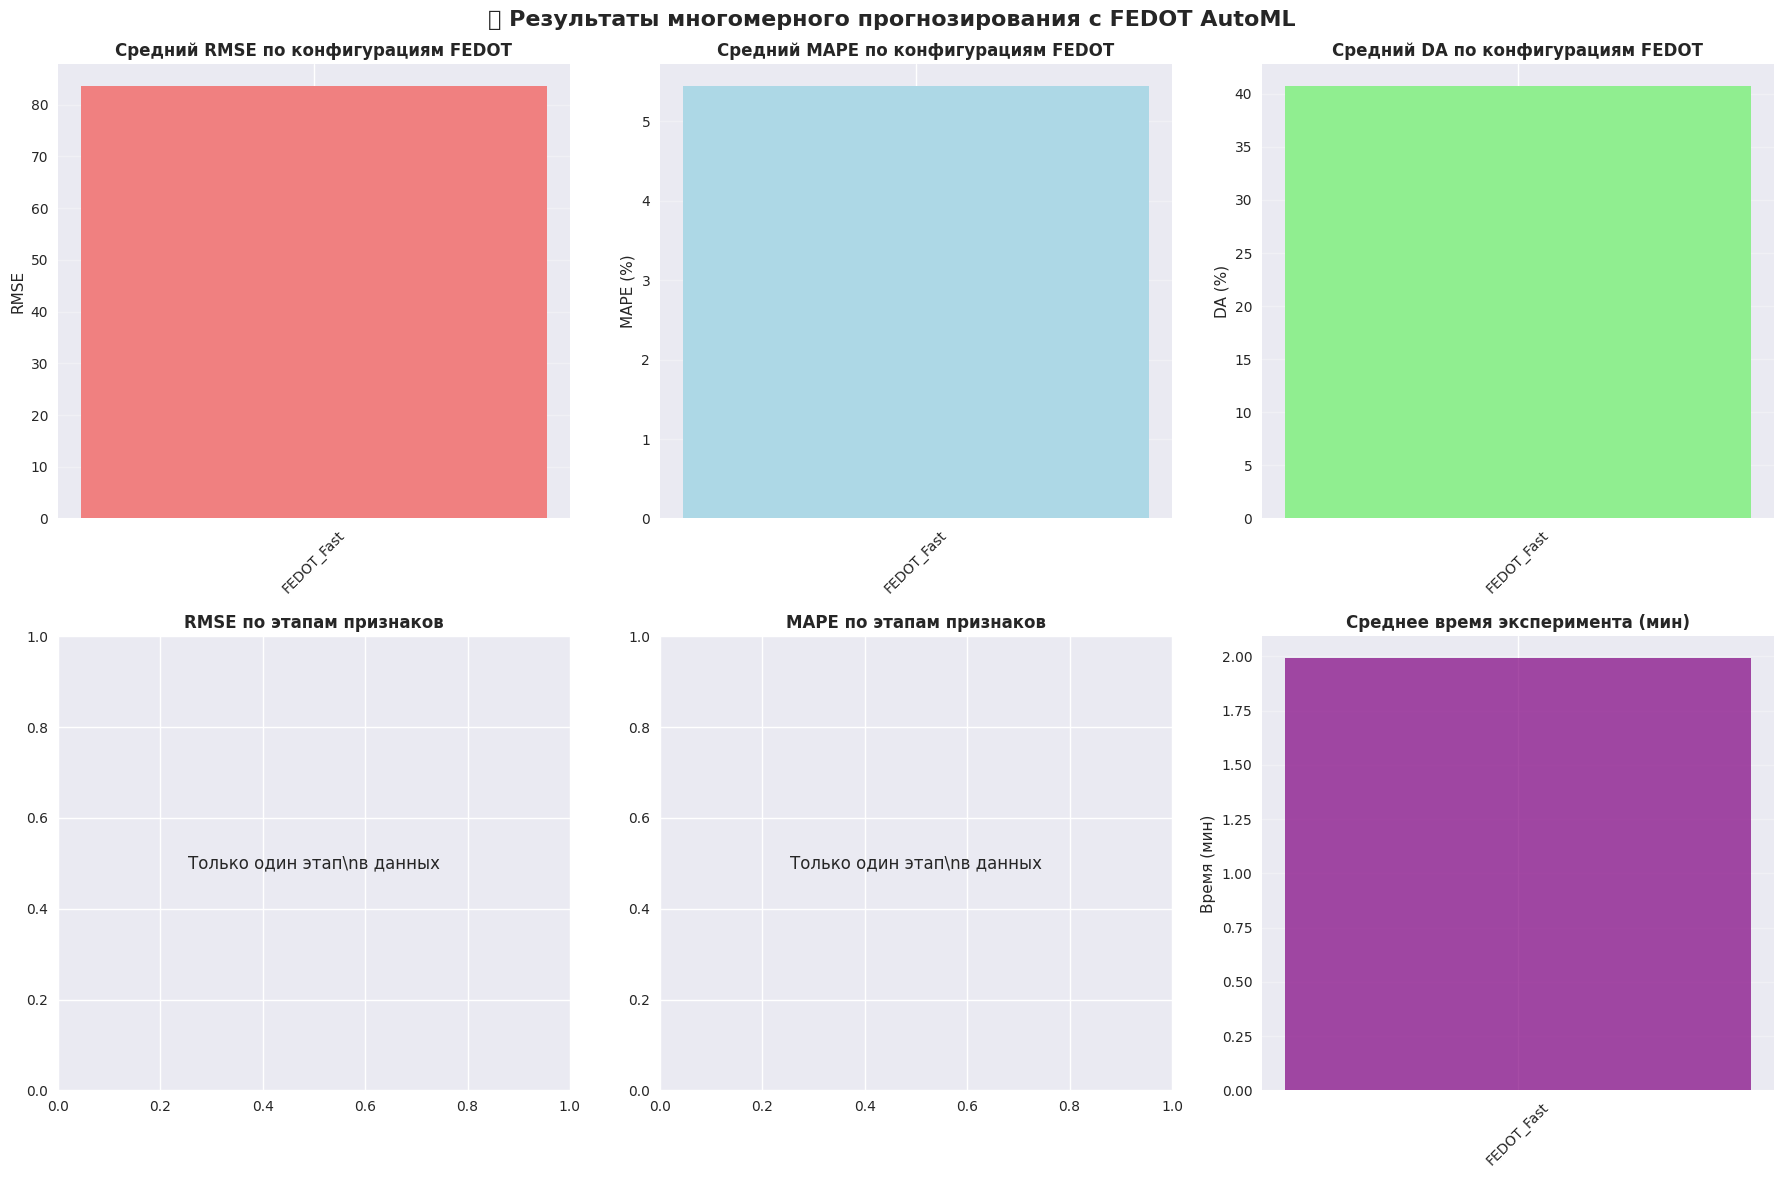

In [11]:
# Визуализация результатов
if results:
    print("📊 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ FEDOT AUTOML")
    print("=" * 50)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('🤖 Результаты многомерного прогнозирования с FEDOT AutoML', fontsize=16, fontweight='bold')
    
    # 1. RMSE по конфигурациям
    config_rmse = df_results.groupby('config_name')['rmse'].mean().sort_values()
    axes[0,0].bar(range(len(config_rmse)), config_rmse.values, color='lightcoral')
    axes[0,0].set_title('Средний RMSE по конфигурациям FEDOT', fontweight='bold')
    axes[0,0].set_ylabel('RMSE')
    axes[0,0].set_xticks(range(len(config_rmse)))
    axes[0,0].set_xticklabels(config_rmse.index, rotation=45)
    axes[0,0].grid(axis='y', alpha=0.3)
    
    # 2. MAPE по конфигурациям
    config_mape = df_results.groupby('config_name')['mape'].mean().sort_values()
    axes[0,1].bar(range(len(config_mape)), config_mape.values, color='lightblue')
    axes[0,1].set_title('Средний MAPE по конфигурациям FEDOT', fontweight='bold')
    axes[0,1].set_ylabel('MAPE (%)')
    axes[0,1].set_xticks(range(len(config_mape)))
    axes[0,1].set_xticklabels(config_mape.index, rotation=45)
    axes[0,1].grid(axis='y', alpha=0.3)
    
    # 3. DA по конфигурациям
    config_da = df_results.groupby('config_name')['da'].mean().sort_values(ascending=False)
    axes[0,2].bar(range(len(config_da)), config_da.values, color='lightgreen')
    axes[0,2].set_title('Средний DA по конфигурациям FEDOT', fontweight='bold')
    axes[0,2].set_ylabel('DA (%)')
    axes[0,2].set_xticks(range(len(config_da)))
    axes[0,2].set_xticklabels(config_da.index, rotation=45)
    axes[0,2].grid(axis='y', alpha=0.3)
    
    # 4. RMSE по этапам
    if df_results['stage'].nunique() > 1:
        stage_rmse = df_results.groupby('stage')['rmse'].mean()
        axes[1,0].plot(stage_rmse.index, stage_rmse.values, marker='o', linewidth=2, markersize=8)
        axes[1,0].set_title('RMSE по этапам признаков', fontweight='bold')
        axes[1,0].set_xlabel('Этап')
        axes[1,0].set_ylabel('RMSE')
        axes[1,0].grid(True, alpha=0.3)
        axes[1,0].set_xticks(stage_rmse.index)
    else:
        axes[1,0].text(0.5, 0.5, 'Только один этап\\nв данных', ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,0].set_title('RMSE по этапам признаков', fontweight='bold')
    
    # 5. MAPE по этапам
    if df_results['stage'].nunique() > 1:
        stage_mape = df_results.groupby('stage')['mape'].mean()
        axes[1,1].plot(stage_mape.index, stage_mape.values, marker='s', linewidth=2, markersize=8, color='orange')
        axes[1,1].set_title('MAPE по этапам признаков', fontweight='bold')
        axes[1,1].set_xlabel('Этап')
        axes[1,1].set_ylabel('MAPE (%)')
        axes[1,1].grid(True, alpha=0.3)
        axes[1,1].set_xticks(stage_mape.index)
    else:
        axes[1,1].text(0.5, 0.5, 'Только один этап\\nв данных', ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('MAPE по этапам признаков', fontweight='bold')
    
    # 6. Время эксперимента по конфигурациям
    config_time = df_results.groupby('config_name')['experiment_time'].mean() / 60  # в минутах
    axes[1,2].bar(range(len(config_time)), config_time.values, color='purple', alpha=0.7)
    axes[1,2].set_title('Среднее время эксперимента (мин)', fontweight='bold')
    axes[1,2].set_ylabel('Время (мин)')
    axes[1,2].set_xticks(range(len(config_time)))
    axes[1,2].set_xticklabels(config_time.index, rotation=45)
    axes[1,2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    # Сохраняем график
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    plot_file = f"{OUTPUT_PATH}multivariate_fedot_comparison_{timestamp}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f"📊 График сохранен: {plot_file}")
    plt.show()
else:
    print("❌ Нет данных для визуализации!")


## 🎯 Заключение по многомерному FEDOT AutoML

Этот блокнот реализует многомерное прогнозирование финансовых временных рядов с использованием **FEDOT AutoML** - российской системы автоматического машинного обучения.

### 🔑 Ключевые особенности реализации:

1. **🤖 AutoML подход**: Автоматический поиск оптимальной архитектуры модели
2. **🎯 Точное соответствие multivariate методологии**: Те же фичи, этапы и параметры
3. **📊 Walk-forward валидация**: TEST_SIZE=11, FORECAST_HORIZON=10
4. **🌟 Композитные пайплайны**: Построение сложных многоуровневых моделей
5. **⚡ Гибкие конфигурации**: От быстрого до сбалансированного поиска

### 🏗️ Архитектурные особенности FEDOT:

- **Эволюционный поиск**: Использует генетические алгоритмы для поиска архитектуры
- **Композитные модели**: Может строить сложные пайплайны из нескольких алгоритмов
- **Автоматическая инженерия признаков**: Самостоятельная подготовка данных
- **Специализация на временных рядах**: Preset 'ts' оптимизирован для TS задач

### 📈 Параметры эксперимента (идентичны другим multivariate блокнотам):

- **TEST_SIZE**: 11 точек
- **FORECAST_HORIZON**: 10 точек  
- **Тикеры**: ['AFLT', 'LKOH', 'MOEX', 'NVTK', 'PIKK', 'SBER', 'VKCO', 'VTBR', 'X5', 'YDEX']
- **Этапы**: [1, 6] (базовая цена и полный набор признаков)

### 🎯 Структура этапов (точно как в других multivariate блокнотах):

1. **Этап 1**: Только цены закрытия (close)
2. **Этап 2**: + Аномалии (anomaly)
3. **Этап 3**: + Новостные настроения (weighted_score_with_decay)
4. **Этап 4**: + OHLCV данные (open, high, low, volume)
5. **Этап 5**: + Технические индикаторы (EMA_14, RSI_14, MACD, return, ATR_14, VWAP)
6. **Этап 6**: + Статистические признаки TSFresh (value__mean, value__maximum, и др.)

### 🔬 Преимущества FEDOT AutoML подхода:

1. **🧠 Автоматический выбор**: Не требует экспертных знаний в ML
2. **🏗️ Композитные архитектуры**: Может найти неочевидные комбинации алгоритмов
3. **🔄 Адаптивность**: Подстраивается под специфику каждого временного ряда
4. **🇷🇺 Российская разработка**: NCCR, ITMO University
5. **📊 Прозрачность**: Возможность анализа найденных архитектур

### ⚠️ Ограничения и соображения:

1. **⏱️ Время поиска**: Требует значительного времени на поиск архитектуры
2. **💾 Ресурсоемкость**: Высокое потребление CPU и памяти
3. **🎲 Стохастичность**: Результаты могут варьироваться между запусками
4. **🔍 Настройка**: Требует тонкой настройки timeout и других параметров

### 🚀 Практические рекомендации:

#### Конфигурации:
- **FEDOT_Fast (2 мин)**: Для быстрых экспериментов и прототипирования
- **FEDOT_Balanced (5 мин)**: Баланс качества и времени для продакшна

#### Настройки:
- **safe_mode=True**: Для стабильности работы
- **cv_folds=3**: Кросс-валидация для оценки качества
- **with_tuning**: Включать для финального обучения
- **early_stopping**: Остановка при отсутствии улучшений

### 🔄 Сравнение с другими multivariate подходами:

| Аспект | ML_DARTS_Multivariate | ML_CHRONOS_Multivariate | ML_FEDOT_Multivariate |
|--------|----------------------|--------------------------|-------------------------|
| **Подход** | Классические ML алгоритмы | Foundation Model | AutoML поиск |
| **Обучение** | Быстрое (секунды) | Zero-shot | Автоматический поиск (минуты) |
| **Архитектура** | Фиксированные модели | Предобученный Transformer | Композитные пайплайны |
| **Настройка** | Ручной выбор параметров | Минимальная | Автоматическая |
| **Гибкость** | Высокая (много алгоритмов) | Ограниченная | Очень высокая |
| **Интерпретируемость** | Высокая | Низкая | Средняя |
| **Экспертиза** | Требует знаний ML | Не требует | Не требует |

### 🏆 Когда использовать FEDOT:

✅ **Рекомендуется:**
- Отсутствие экспертизы в машинном обучении
- Необходимость найти лучшую модель без ограничений
- Сложные временные ряды с нестандартными паттернами
- Готовность ждать результата качественного поиска
- Исследовательские задачи

❌ **Не рекомендуется:**
- Требования к быстрому результату
- Ограниченные вычислительные ресурсы
- Необходимость полной интерпретируемости
- Простые временные ряды с очевидными паттернами

**FEDOT AutoML представляет собой мощный инструмент для автоматического построения моделей прогнозирования временных рядов, особенно ценный когда нужно найти оптимальное решение без глубоких знаний в области машинного обучения!** 🤖✨
